<a href="https://colab.research.google.com/github/Ulasus123/METUSTAT_DATATHON_PRELIM/blob/main/DataYouth_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation

Imporing data and necessary libraries

In [162]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')


In [163]:
data = pd.read_excel("/content/drive/MyDrive/Datathon_Plant_X.xlsx")

# Data Exploration

Data is explored in this section.

In [164]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10897 entries, 0 to 10896
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10897 non-null  object 
 1   Y1          10896 non-null  float64
 2   Y2          10896 non-null  float64
 3   E1          63 non-null     float64
 4   E2          64 non-null     float64
 5   A1          10896 non-null  float64
 6   Y3          10896 non-null  float64
 7   Y4          10896 non-null  float64
 8   Y5          10896 non-null  float64
 9   Y6          10896 non-null  float64
 10  U1          10896 non-null  float64
 11  U2          10896 non-null  float64
 12  O1          10897 non-null  float64
 13  O2          10897 non-null  float64
 14  D           438 non-null    float64
dtypes: float64(14), object(1)
memory usage: 1.2+ MB


In this description, it is obvious that the data is multivariate and it has NaN values.

Making a DataFrame and starting data manipulation

In [165]:
data = pd.DataFrame(data)
data = data.rename(columns={'Unnamed: 0': 'Time'})

Name of the datetime column should be changed to time, it is better to use.

In [166]:
data['Time'] = pd.to_datetime(data['Time'], infer_datetime_format=True, errors='coerce')

Time data is found erroneous, there was the date 15-02-29. errors='coerce' method is used to ignore those. This method converts inappopriately written data into the type of NaT

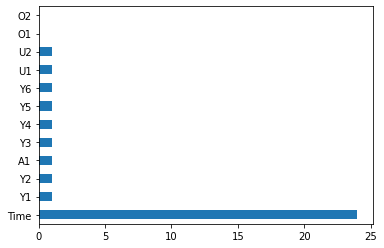

In [167]:
#Sütunlara ait NA sayıları
missing_values_count = data.loc[:,  ~data.columns.isin(['E1', 'E2', 'D'])].isnull().sum()
missing_values_count.plot(kind='barh')
plt.show()

It is shown that there is 24 null time values, all others have only 1.

Now, we will analyse null year values.

In [168]:
#It is understood that date variable has NaT values, which increased suspicion of date shift.
bool_series = pd.isnull(data["Time"])
 
# filtering data
# displayind data only with date = NaT
data[bool_series]

,Time,Y1,Y2,E1,E2,A1,Y3,Y4,Y5,Y6,U1,U2,O1,O2,D
6961,NaT,3.713691,7.833662,NaN,NaN,2927.646514,39.423319,17.402278,23.934515,11.445910,749.009687,6805.638428,2.6433,10474.478070,NaN
6962,NaT,3.781891,8.041439,NaN,NaN,2930.711418,38.710016,17.294647,23.975923,11.518775,749.161132,6808.783440,0.8811,11205.093736,NaN
6963,NaT,3.740482,8.270619,NaN,NaN,2940.982877,39.397577,17.346239,24.017305,11.462784,749.133078,6804.949752,0.8811,12945.485774,NaN
6964,NaT,3.794038,8.213115,NaN,NaN,2852.294540,38.155675,17.074552,23.909258,11.411894,748.521705,6810.435895,0.8811,9445.289073,NaN
6965,NaT,3.928669,8.723220,NaN,NaN,2849.997096,41.841134,17.806830,24.125685,11.576763,748.453199,6811.975877,3.5244,8539.055939,NaN
6966,NaT,4.095577,8.530024,NaN,NaN,2865.137335,39.739011,17.213133,23.869066,11.437353,748.622570,6808.705543,1.7622,11376.276477,NaN
6967,NaT,4.007351,8.387160,NaN,NaN,2844.652560,38.311348,17.376339,23.977569,11.302470,748.372984,6810.968163,0.8811,12280.794858,NaN
6968,NaT,3.921849,8.241040,NaN,NaN,2828.889769,35.570539,17.154727,24.008265,11.091558,748.568465,6813.246971,0.8811,11240.229556,NaN
6969,NaT,3.846653,7.852439,NaN,NaN,2844.311588,36.849830,17.792510,24.182224,11.055356,748.812460,6807.837483,0.8811,13844.760617,NaN
6970,NaT,3.925672,7.860153,NaN,NaN,2840.668367,38.846755,17.907822,24.453698,11.255930,748.565772,6808.875500,3.5244,11295.426038,NaN


In [169]:
# The data has significant, it has important values, hence it is profiable to shift the dates by 1 day.

data_to_change = data.iloc[6961:6985, :]
data_stack = data.iloc[6986:, :]

data_stack = data_stack.set_index('Time')
data_stack.head()
data_stack = data_stack.shift(1, freq = 'D')

In [170]:
data_stack = data_stack.reset_index() 

changed_data = pd.Series(dt.datetime(2015, 3, 1, x, 0, 0) for x in range(0, 24))
data_to_change['Time'][:] = changed_data
data.iloc[6961:6985, :] = data_to_change
data.iloc[6986:, :] = data_stack

In [171]:
data['date'] = data['Time'].map(lambda x: x.strftime('%Y-%m-%d'))
data['year'] = data['Time'].dt.year
data['month'] = data['Time'].dt.month
data['day'] = data['Time'].dt.day
data['hour'] = data['Time'].dt.hour
data['minute'] = data['Time'].dt.minute
data['day_of_week'] = data['Time'].dt.dayofweek
data.head()

,Time,Y1,Y2,E1,E2,A1,Y3,Y4,Y5,Y6,...,O1,O2,D,date,year,month,day,hour,minute,day_of_week
0,2014-05-15 00:00:00,3.200980,9.658993,NaN,NaN,4448.771308,33.471559,14.767730,19.796307,15.725165,...,2.6433,10768.178760,NaN,2014-05-15,2014,5,15,0,0,3
1,2014-05-15 01:00:00,3.615716,9.302299,NaN,NaN,4442.398566,33.421821,14.845213,19.950811,16.305541,...,2.6433,9895.346884,NaN,2014-05-15,2014,5,15,1,0,3
2,2014-05-15 02:00:00,3.748671,9.526543,NaN,NaN,4447.961145,33.784009,15.387849,20.214004,17.253103,...,0.8811,9039.178904,NaN,2014-05-15,2014,5,15,2,0,3
3,2014-05-15 03:00:00,3.828601,9.540441,NaN,NaN,4446.466744,31.479599,14.830375,20.323768,17.994465,...,0.8811,11391.700931,NaN,2014-05-15,2014,5,15,3,0,3
4,2014-05-15 04:00:00,3.880042,9.704919,NaN,NaN,4454.121402,34.578727,16.221921,20.945486,18.570945,...,1.7622,10656.509979,NaN,2014-05-15,2014,5,15,4,0,3


In [172]:
# Checking any NaT values left

data[bool_series]

,Time,Y1,Y2,E1,E2,A1,Y3,Y4,Y5,Y6,...,O1,O2,D,date,year,month,day,hour,minute,day_of_week
6961,2015-03-01 00:00:00,3.713691,7.833662,NaN,NaN,2927.646514,39.423319,17.402278,23.934515,11.445910,...,2.6433,10474.478070,NaN,2015-03-01,2015,3,1,0,0,6
6962,2015-03-01 01:00:00,3.781891,8.041439,NaN,NaN,2930.711418,38.710016,17.294647,23.975923,11.518775,...,0.8811,11205.093736,NaN,2015-03-01,2015,3,1,1,0,6
6963,2015-03-01 02:00:00,3.740482,8.270619,NaN,NaN,2940.982877,39.397577,17.346239,24.017305,11.462784,...,0.8811,12945.485774,NaN,2015-03-01,2015,3,1,2,0,6
6964,2015-03-01 03:00:00,3.794038,8.213115,NaN,NaN,2852.294540,38.155675,17.074552,23.909258,11.411894,...,0.8811,9445.289073,NaN,2015-03-01,2015,3,1,3,0,6
6965,2015-03-01 04:00:00,3.928669,8.723220,NaN,NaN,2849.997096,41.841134,17.806830,24.125685,11.576763,...,3.5244,8539.055939,NaN,2015-03-01,2015,3,1,4,0,6
6966,2015-03-01 05:00:00,4.095577,8.530024,NaN,NaN,2865.137335,39.739011,17.213133,23.869066,11.437353,...,1.7622,11376.276477,NaN,2015-03-01,2015,3,1,5,0,6
6967,2015-03-01 06:00:00,4.007351,8.387160,NaN,NaN,2844.652560,38.311348,17.376339,23.977569,11.302470,...,0.8811,12280.794858,NaN,2015-03-01,2015,3,1,6,0,6
6968,2015-03-01 07:00:00,3.921849,8.241040,NaN,NaN,2828.889769,35.570539,17.154727,24.008265,11.091558,...,0.8811,11240.229556,NaN,2015-03-01,2015,3,1,7,0,6
6969,2015-03-01 08:00:00,3.846653,7.852439,NaN,NaN,2844.311588,36.849830,17.792510,24.182224,11.055356,...,0.8811,13844.760617,NaN,2015-03-01,2015,3,1,8,0,6
6970,2015-03-01 09:00:00,3.925672,7.860153,NaN,NaN,2840.668367,38.846755,17.907822,24.453698,11.255930,...,3.5244,11295.426038,NaN,2015-03-01,2015,3,1,9,0,6


 We will try to see which columns has the NaN's.

In [173]:
data.loc[data['Y1'].isnull()==True]

,Time,Y1,Y2,E1,E2,A1,Y3,Y4,Y5,Y6,...,O1,O2,D,date,year,month,day,hour,minute,day_of_week
154,2014-05-21 09:55:00,NaN,NaN,NaN,0.9345,NaN,NaN,NaN,NaN,NaN,...,0.8811,11110.260928,NaN,2014-05-21,2014,5,21,9,55,2


Luckily, all the NaN values are in the same row. Note that the hour that this measurement is taken is 09.55, it can be claimed that it is definitely a sensor error. Now it's time to remove it.

In [174]:
data = data.loc[data['Y1'].isnull()==False]

Now it's time to deal with multivariateness. A common analytical approach is to estimate the other frequency values using time-based interpolation. 

In [175]:
data = data.set_index('Time')

data.loc[:, ['E1','E2', 'D']] = data.loc[:, ['E1','E2', 'D']].interpolate(method='time', limit_direction='backward')
data.loc[:, ['E1','E2', 'D']] = data.loc[:, ['E1','E2', 'D']].interpolate(method='time', limit_direction='forward')

Now, time is the index and time-based interpolation is performed. Observe that limit direction is applied twice, once backward and once forward. The value 'D' is measured only once per day. Backward interpolation is hence applied firstly. Forward interpolation is applied after it as backward interpolation leaves some NaN values. Characteristic of E1 and E2 are not thoroughly known, hence the same principle is applied. 

Checking the amount of missing values.

In [176]:
#Sütunlara ait NA sayıları
missing_values_count = data.isnull().sum()
print(missing_values_count)

Y1             0
Y2             0
E1             0
E2             0
A1             0
Y3             0
Y4             0
Y5             0
Y6             0
U1             0
U2             0
O1             0
O2             0
D              0
date           0
year           0
month          0
day            0
hour           0
minute         0
day_of_week    0
dtype: int64


# Data Visualization

In this chapter, relations of features will be shown graphically.

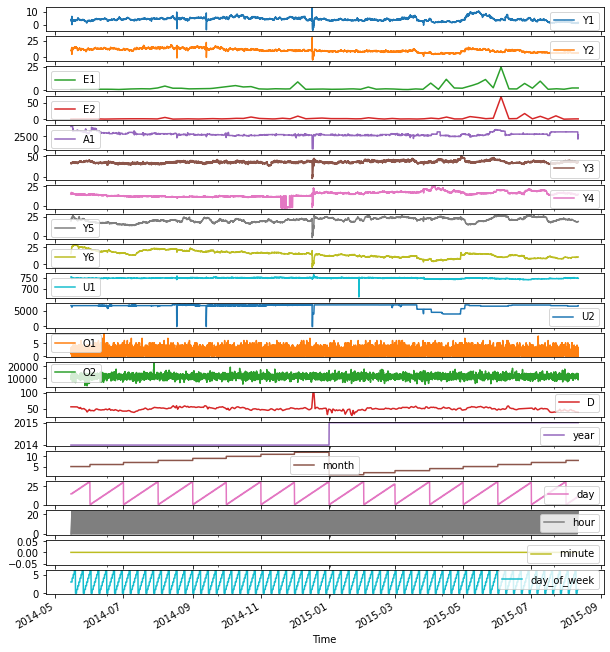

In [177]:
# Final distribution of all features by time.

data.plot(subplots=True, figsize=(10, 12))
plt.show()

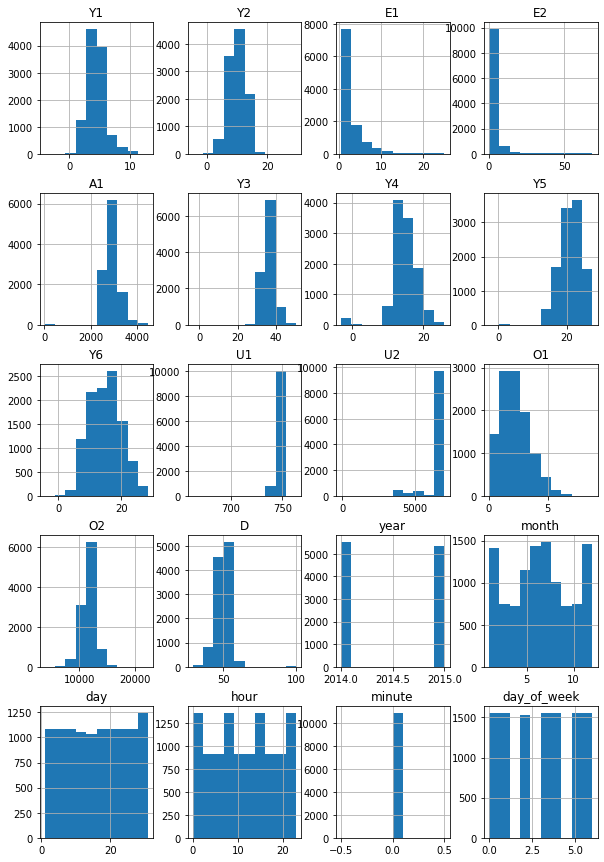

In [178]:
# Histogram plot

data.hist(figsize=(10,15))
plt.show()

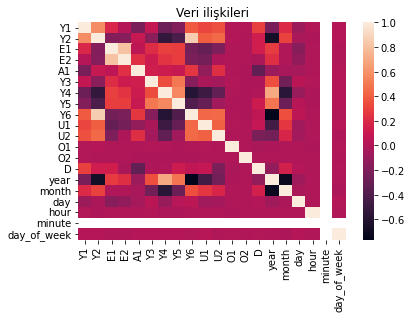

In [179]:
# Correlation Heatmap

sns.heatmap(data.corr())
plt.title('Veri ilişkileri')
plt.show()

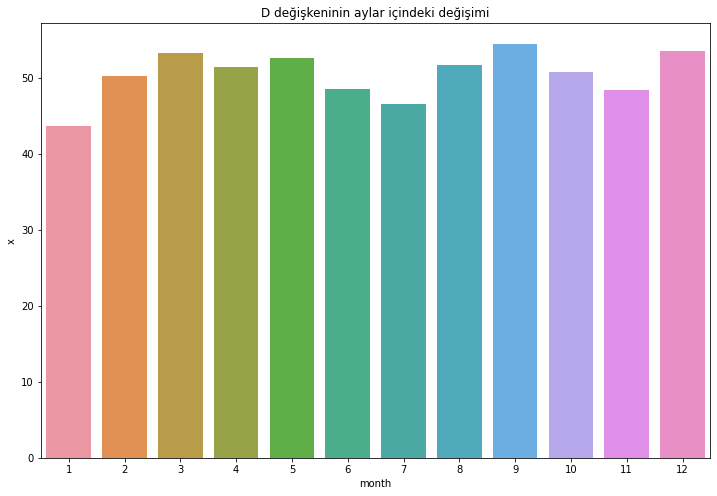

In [180]:
plt.figure(figsize=(12,8))
ax = sns.barplot(x=data.groupby('month').D.mean().index, y=data.groupby('month').D.mean().values, data=data)
ax.set_title('y')
ax.set_ylabel('x')
plt.title('D değişkeninin aylar içindeki değişimi')
plt.show()

There are some closely correlated features (such as Y6 and Y2), they can be used later on in the feature extraction.

Now, columns which include strings will be dropped.

In [181]:
data.drop(data.loc[:, 'date':], inplace=True, axis=1)

# Stationarity Analysis

Stationarity analysis is important in time series. When the data is not stationary, which means not changing smoothly, this could cause unstable predictions. If the series is not stationary, smoothing should be applied.

In [182]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

from statsmodels.tsa.stattools import adfuller
for name, column in data.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Y1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.8163
 No. Lags Chosen       = 37
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Y2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.4568
 No. Lags Chosen       = 39
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0092. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "E1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.0

In [183]:
fit1 = Holt(abs(data['Y1'])).fit(smoothing_level=0.8)
fcast1 = fit1.forecast(5).rename("Holt's linear trend")
fit2 = Holt(abs(data['Y2']), exponential=True).fit(smoothing_level=0.8)
fcast2 = fit2.forecast(5).rename("Exponential trend")
fit3 = Holt(abs(data['Y3'])).fit(smoothing_level=0.8)
fcast3 = fit3.forecast(5).rename("Additive damped trend")
fit5 = Holt(abs(data['Y5'])).fit(smoothing_level=0.8)
fcast5 = fit5.forecast(5).rename("Additive damped trend")
fit6 = Holt(abs(data['Y6'])).fit(smoothing_level=0.8)
fcast6 = fit6.forecast(5).rename("Additive damped trend")
fitE1 = Holt(abs(data['E1'])).fit(smoothing_level=0.8)
fcastE1 = fitE1.forecast(5).rename("Additive damped trend")
fitE2 = Holt(abs(data['E2'])).fit(smoothing_level=0.8)
fcastE2 = fitE2.forecast(5).rename("Additive damped trend")
fitU1 = Holt(abs(data['U1'])).fit(smoothing_level=0.8)
fcastU1 = fitU1.forecast(5).rename("Additive damped trend")
fitU2 = Holt(abs(data['U2'])).fit(smoothing_level=0.8)
fcastU2 = fitU2.forecast(5).rename("Additive damped trend")
fitA1 = Holt(abs(data['A1'])).fit(smoothing_level=0.8)
fcastA1 = fitA1.forecast(5).rename("Additive damped trend")
fitO1 = Holt(abs(data['O1'])).fit(smoothing_level=0.8)
fcastO1 = fitO1.forecast(5).rename("Additive damped trend")
fitO2 = Holt(abs(data['O2'])).fit(smoothing_level=0.8)
fcastO2 = fitO2.forecast(5).rename("Additive damped trend")
fitD = Holt(abs(data['D'])).fit(smoothing_level=0.8)
fcastD = fitD.forecast(5).rename("Additive damped trend")

In [184]:
forecast_data = pd.DataFrame([fcast1, fcast2, fcast3, fcast5, fcast6, fcastE1, fcastE2, fcastU1, fcastU2, fcastA1, fcastO1, fcastO2, fcastD], 
                             columns=['fcast1', 'fcast2', 'fcast3', 'fcast5, fcast6', 'fcastE1', 'fcastE2', 'fcastU1', 'fcastU2', 'fcastO1', 'fcastO2', 'fcastD' ])

All columns except Y4 is now proved not to have a trend. Smoothing for Y4 will be applied.

Final distribution of the code is as follows:

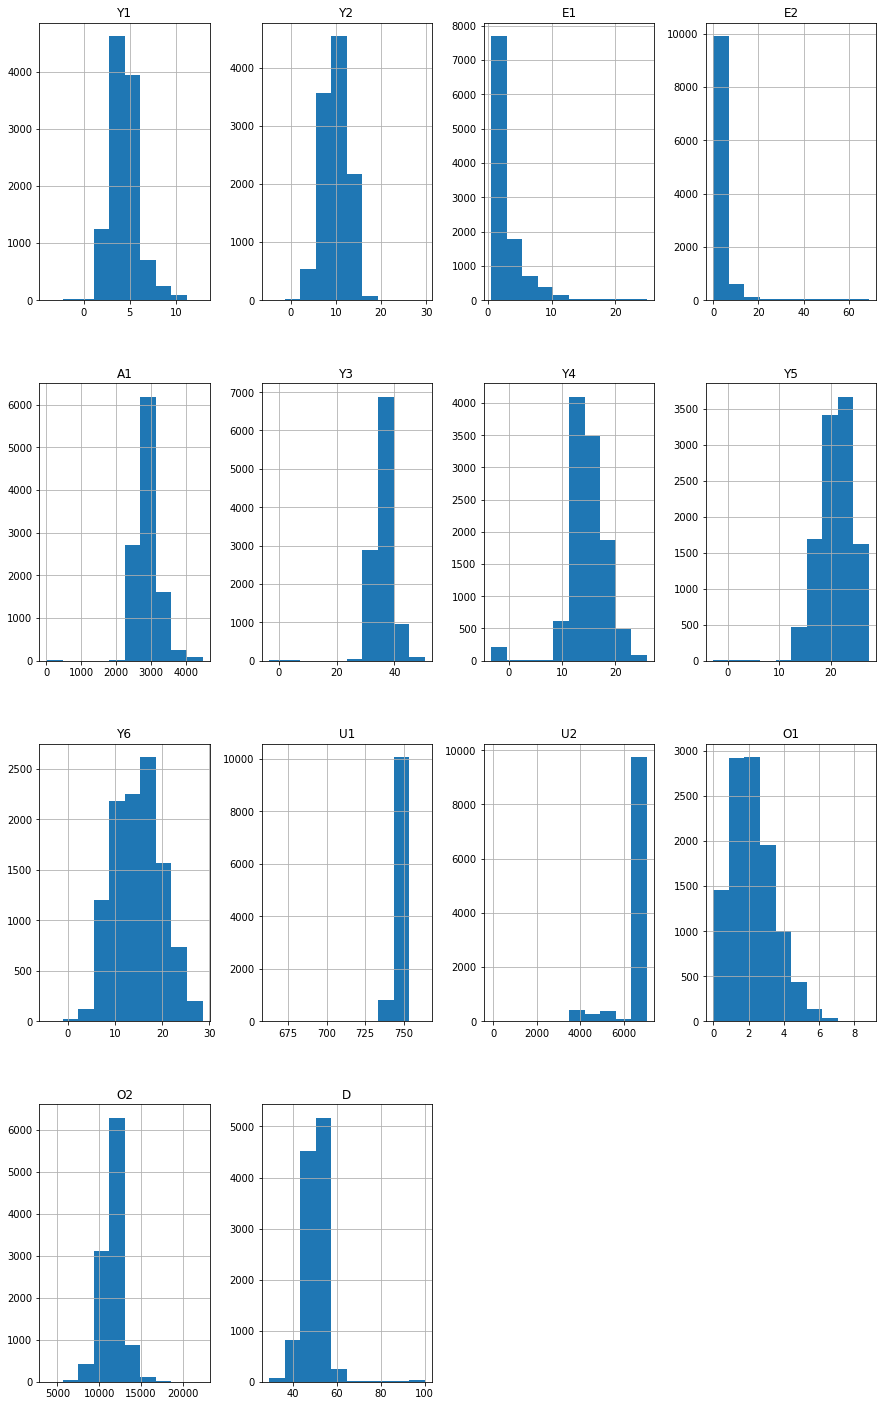

In [185]:
data.hist(figsize=(15,25))
plt.show()

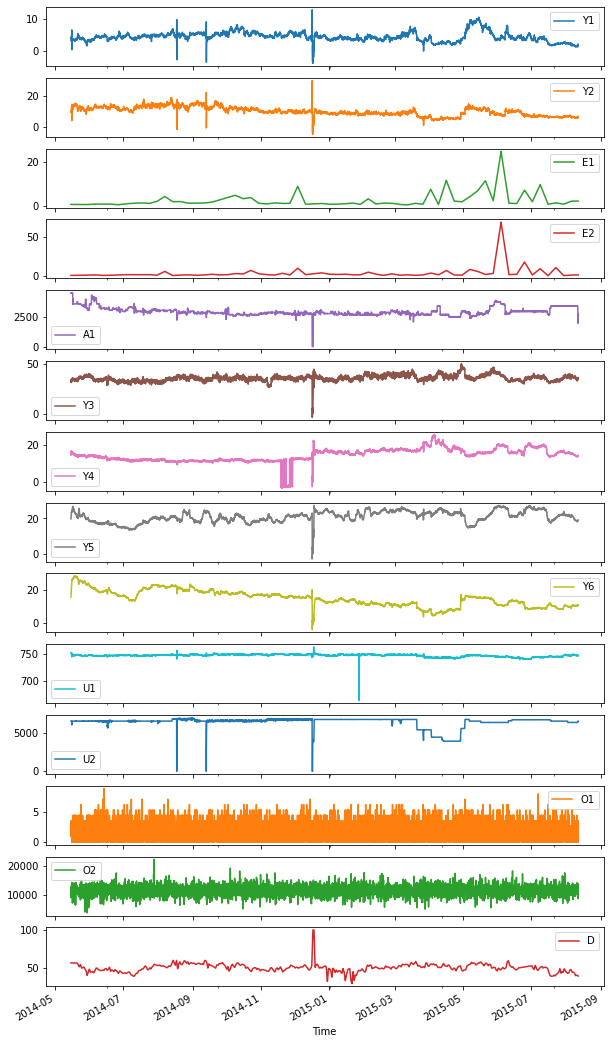

In [186]:
data.plot(subplots=True, figsize=(10,20))
plt.show()

### Outlier Handling

There are certain outliers in this data. We will implement a function for imputing such outlier values.

In [191]:
#data = data.reset_index('Time')
time = data['Time']
data.drop('Time', axis=1, inplace=True)
columns = data.columns

scaler = StandardScaler()
data = scaler.fit_transform(data)

data = pd.DataFrame(data, columns=columns)
data = data.set_index(time)

If a median imputation is applied to seemingly outlier data, the problem would be resolved.

In [192]:
def handle_outlier(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    med = np.median(data)
    for i in data:
      if i > Upper_tail or i < Lower_tail:
        data = data.replace(i, med)
    return data

In [193]:
for each in data.columns:
  data[each] = handle_outlier(data[each])

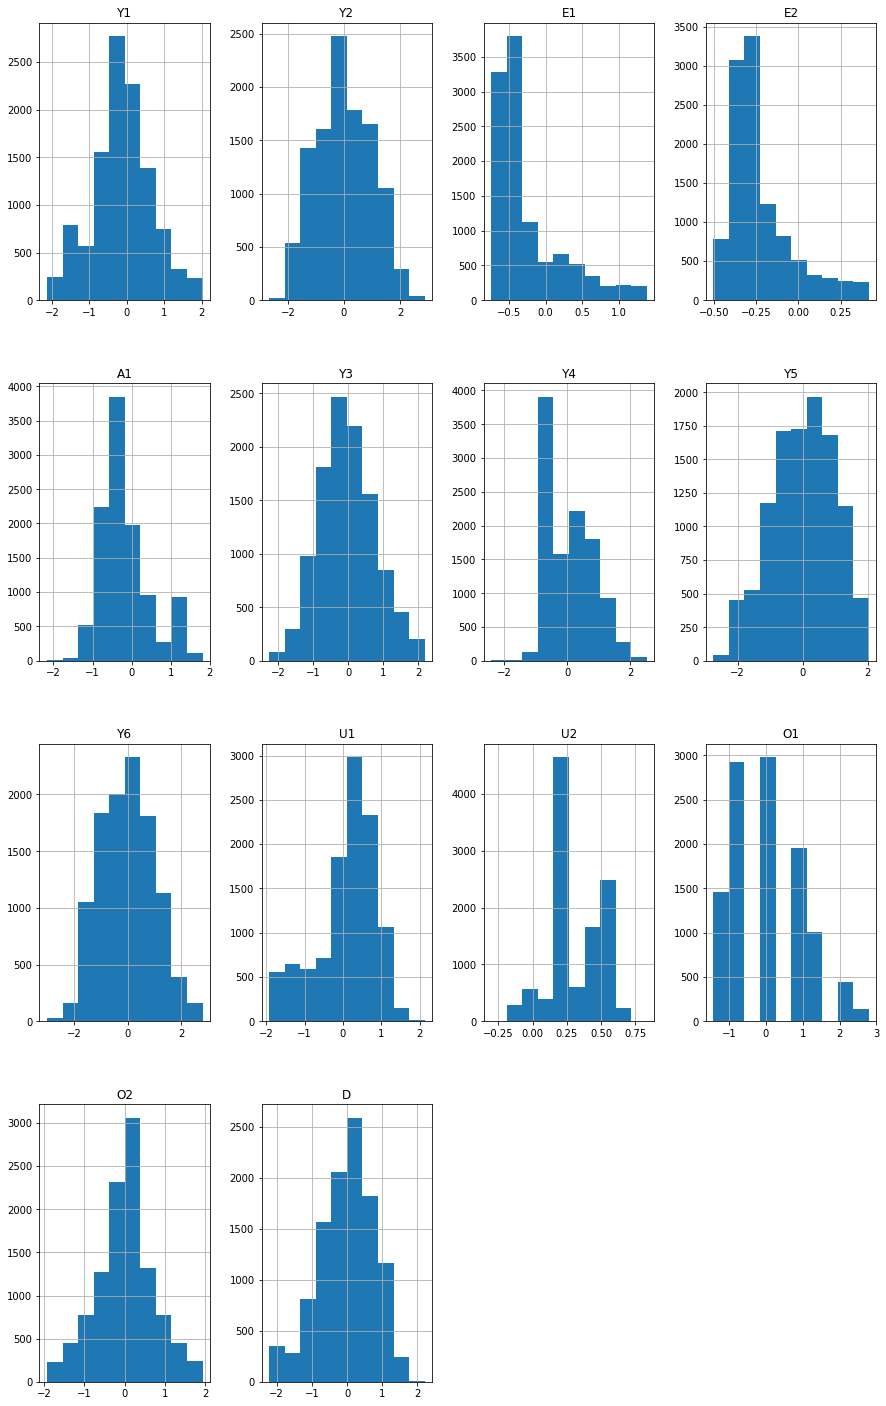

In [194]:
data.hist(figsize=(15,25))
plt.title('Outlier Handling\'den Sonra Oluşan Dağılım Grafiği')
plt.show()

# Prediction and Forecasting

## Prediction

Now it is time for forecasting. We will first separate train and test values. In most values, train_test_split method is a good method for this purpose, although we need to separate our data depending on time, so a different strategy will be followed.

In [196]:
# split dataset into input and output columns
eighty_percent=int(len(data)*0.8)
train_data = data.iloc[:eighty_percent, :]
test_data = data.iloc[eighty_percent+1:, :]

X_train, y_train = train_data.iloc[:, :-1], train_data.iloc[:, -1]
X_test, y_test = test_data.iloc[:, :-1], test_data.iloc[:, -1]

XGBoost Regression is a very efficient technique in general. It is proved successful in many applications, with nicely tuned hyperparameters.

In [201]:
reg = XGBRegressor(
    random_state=42,
    tree_method="hist",
    gpu_id=0,
    n_estimators=7000,
)
reg.fit(X_train, y_train)
plt.show()

[06:55:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [202]:
test_data['D_predicted'] = reg.predict(X_test)
data = pd.concat([test_data, train_data], sort=False)

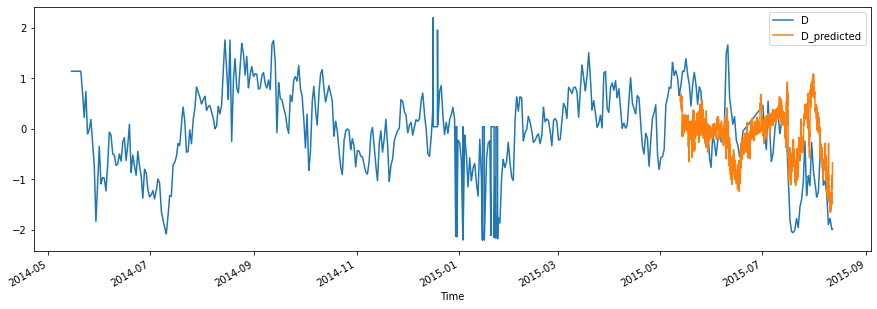

In [203]:
data[['D','D_predicted']].plot(figsize=(15, 5))
plt.show()

In [204]:
# Error metrics comparison

errors = [mean_absolute_error(test_data['D'], test_data['D_predicted']), mean_squared_error(test_data['D'], test_data['D_predicted'])]
labels = ['MAE', 'MSE']
columns = ['Error']
error_comp = pd.DataFrame(errors, labels, columns)
error_comp

,Error
MAE,0.638952
MSE,0.643176


Error ratio is actually good. This shows that the XGBoost is a good algorithm for such time series prediction.

## Forecast

In time series data, important and one of the hardest parts is to predict the future. ARIMA will be used for this purpose. 